In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataMergerDoubleEntry, DataPreprocessor

%matplotlib inline

In [99]:
# name, epidemicforecasting.org code, OxCGRT code
# + lithuania
region_info = [
    ("Andorra", "AD", "AND"),
    ("Austria", "AT",  "AUT"),
    ("Albania","AL","ALB"),
    ("Bosnia and Herzegovina", "BA", "BIH"),
    ("Belgium", "BE", "BEL"),
    ("Bulgaria",  "BG", "BGR"),
    ("Switzerland", "CH", "CHE"),
    ("Czech Republic", "CZ", "CZE"),
    ("Germany", "DE", "DEU"),
    ("Denmark", "DK", "DNK"),
    ("Estonia","EE", "EST"),
    ("Spain", "ES", "ESP"),
    ("Finland", "FI", "FIN"),
    ("France", "FR", "FRA"),
    ("United Kingdom", "GB", "GBR"), 
    ("Georgia","GE","GEO"),
    ("Greece", "GR", "GRC"),
    ("Croatia", "HR", "HRV"),
    ("Hungary", "HU", "HUN"),
    ("Ireland", "IE", "IRL"),
    ("Israel", "IL", "ISR"),
    ("Iceland", "IS", "ISL"),
    ("Italy", "IT", "ITA"),
    ("Lithuania","LT","LTU"),
    ("Latvia","LV","LVA"),
    ("Malta","MT","MLT"),
    ("Morocco", "MA", "MAR"),
    ("Mexico","MX", "MEX"),
    ("Malaysia", "MY", "MYS"),
    ("Netherlands", "NL", "NLD"),
    ("Norway","NO","NOR"),
    ("New Zealand","NZ","NZL"),
    ("Poland","PL", "POL"),
    ("Portugal","PT","PRT"),
    ("Romania","RO", "ROU"),
    ("Serbia", "RS", "SRB"),
    ("Sweden", "SE", "SWE"),
    ("Singapore", "SG", "SGP"),
    ("Slovenia", "SI", "SVN"),
    ("Slovakia", "SK", "SVK"),
    ("South Africa", "ZA",  "ZAF"),
]

region_info.sort(key = lambda x: x[0])
region_names = list([x for x, _, _ in region_info])
regions_epi = list([x for _, x, _ in region_info])
regions_oxcgrt = list([x for _, _, x in region_info])

# OxCGRT
oxcgrt_cm_cols = ["H2_Testing policy", "C8_International travel controls", "C5_Close public transport", "C5_Flag", "C7_Restrictions on internal movement", "C7_Flag", "H1_Public information campaigns", "H1_Flag"]

oxcgrt_filter = [
    ("Symptomatic Testing", [(0, [2, 3])]),
    ("Travel Screen/Quarantine", [(1, [1, 2, 3, 4])]),
    ("Travel Bans", [(1, [3, 4])]),
    ("Public Transport Limited", [(2, [1, 2]), (3, [1])]),
    ("Internal Movement Limited", [(4, [1, 2]), (5, [1])]),
    ("Public Information Campaigns", [(6, [1, 2]), (7, [1])])
]

epifor_features = {
 "Mask Wearing": "Mask Wearing",
 "Gatherings <1000": "Gatherings <1000",
 "Gatherings <100": "Gatherings <100",
 "Gatherings <10": "Gatherings <10",
 "Some Businesses Suspended": "Some Businesses Suspended",
 "Most Businesses Suspended": "Most Businesses Suspended",
 "School Closure": "School Closure",
 "University Closure": "University Closure",
 "Stay Home Order": "Stay Home Order"
}


final_features = [
 "Mask Wearing",
 "Symptomatic Testing",
 "Gatherings <1000",
 "Gatherings <100",
 "Gatherings <10",
 "Some Businesses Suspended",
 "Most Businesses Suspended",
 "School Closure",
 "University Closure",
 "Stay Home Order",
 "Travel Screen/Quarantine",
 "Travel Bans",
 "Public Transport Limited", 
 "Internal Movement Limited", 
 "Public Information Campaigns",
]

In [100]:
dm = DataMergerDoubleEntry(start_date="2020-1-22", end_date="2020-5-30")
df = dm.merge_data("../../data", region_info, oxcgrt_filter,  oxcgrt_cm_cols,
            epifor_features,
            final_features, "double_entry_final.csv")

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures: EpidemicForecasting.org           min   ... mean  ... max   ... unique
 1 Mask Wearing                               0.000 ... 0.207 ... 1.000 ... [0. 1.]
 2 Gatherings <1000                           0.000 ... 0.611 ... 1.000 ... [0. 1.]
 3 Gatherings <100                            0.000 ... 0.581 ... 1.000 ... [0. 1.]
 4 Gatherings <10                             0.000 ... 0.459 ... 1.000 ... [0. 1.]
 5 Some Businesses Suspended                  0.000 ... 0.547 ... 1.000 ... [0. 1.]
 6 Most Businesses Suspended                  0.000 ... 0.341 ... 1.000 ... [0. 1.]
 7 School Closure                             0.000 ... 0.534 ... 1.000 ... [0. 1.]
 8 University Closure                         0.000 ... 0.568 ... 1.000 ... [0. 1.]
 9 Stay Home Order                            0.000 ... 0.236 ... 1.000 ... [0. 1.]
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Load OXCGRT
INFO:epimodel.pymc3_models.cm_effec

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Screen/Quarantine
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Bans
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Transport Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Internal Movement Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Information Campaigns
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Georgia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Singapore
IN

[('北', 'black'), ('\uf492', 'mediumblue'), ('\uf0c0', 'lightgrey'), ('\uf0c0', 'grey'), ('\uf0c0', 'black'), ('\uf07a', 'tab:orange'), ('\uf07a', 'tab:red'), ('\uf549', 'black'), ('\uf19d', 'black'), ('便', 'black'), ('\uf072', 'grey'), ('\uf072', 'black'), ('\uf238', 'black'), ('\uf1b9', 'black'), ('\uf641', 'black')]


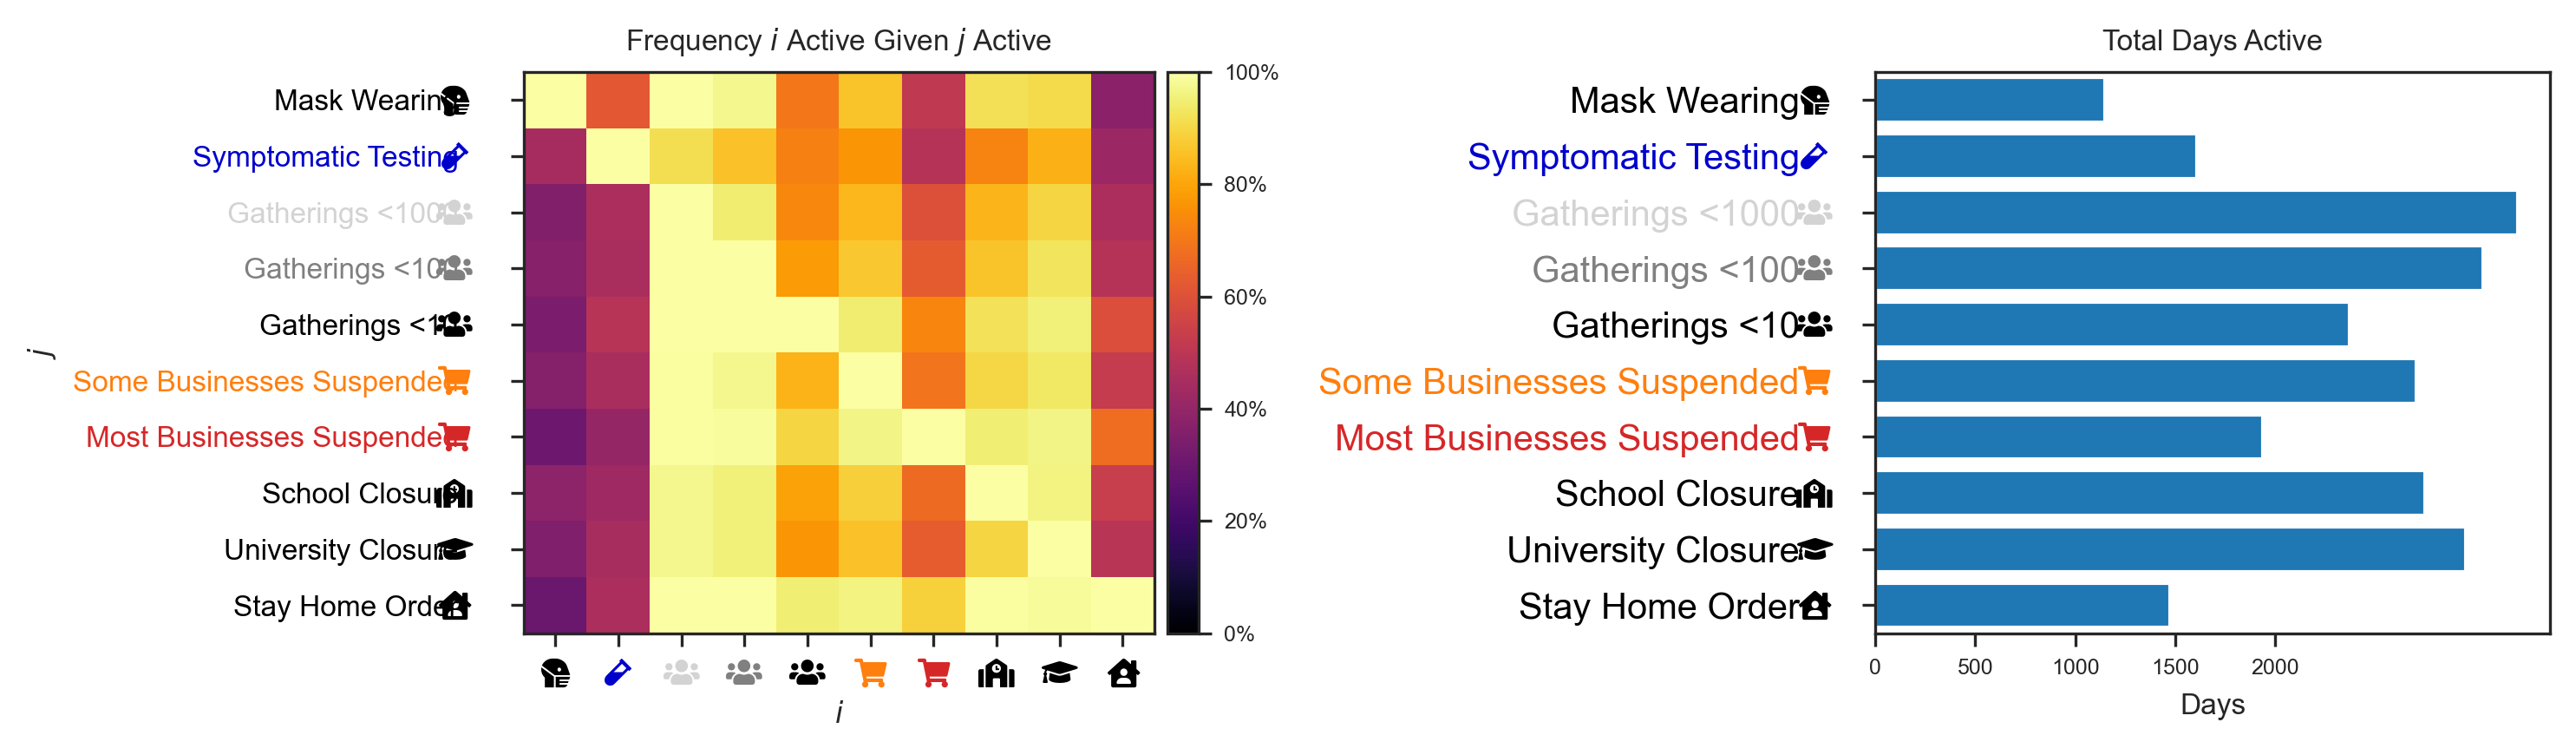

In [72]:
dp = DataPreprocessor()
data = dp.preprocess_data("double_entry_with_OxCGRT.csv", last_day="2020-05-30")

cm_plot_style = [
#             ("\uf7f2", "tab:red"), # hospital symbol
            ("\uf963", "black"), # mask
            ("\uf492", "mediumblue"), # vial
            ("\uf0c0", "lightgrey"), # ppl
            ("\uf0c0", "grey"), # ppl
            ("\uf0c0", "black"), # ppl
            ("\uf07a", "tab:orange"), # shop 1
            ("\uf07a", "tab:red"), # shop2
            ("\uf549", "black"), # school
            ("\uf19d", "black"), # university
            ("\uf965", "black"), # home
            ("\uf072", "grey"), # plane1
            ("\uf072", "black"), # plane2
            ("\uf238", "black"), # train
            ("\uf1b9", "black"), # car
            ("\uf641", "black") # flyer
        ]
data.summary_plot(cm_plot_style)

In [75]:
data.ActiveCMs.shape

(41, 10, 130)

In [76]:
data.ActiveCMs.reshape((41*130, 10))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [77]:
np.corrcoef(data.ActiveCMs.reshape((41*130, 10)), rowvar=False)

array([[1.        , 0.97929881, 0.96532738, 0.94564697, 0.91476243,
        0.90506287, 0.88794128, 0.8688574 , 0.85896217, 0.843594  ],
       [0.97929881, 1.        , 0.98583723, 0.96622376, 0.93498374,
        0.92522064, 0.9078987 , 0.88875902, 0.87871447, 0.8633258 ],
       [0.96532738, 0.98583723, 1.        , 0.98042543, 0.94895389,
        0.9391487 , 0.92169658, 0.90251811, 0.89237721, 0.87697282],
       [0.94564697, 0.96622376, 0.98042543, 1.        , 0.96847573,
        0.95866048, 0.94118337, 0.92199392, 0.91183798, 0.8964277 ],
       [0.91476243, 0.93498374, 0.94895389, 0.96847573, 1.        ,
        0.99009673, 0.97235312, 0.95307866, 0.94272712, 0.92727944],
       [0.90506287, 0.92522064, 0.9391487 , 0.95866048, 0.99009673,
        1.        , 0.98219462, 0.96289916, 0.95250297, 0.93704546],
       [0.88794128, 0.9078987 , 0.92169658, 0.94118337, 0.97235312,
        0.98219462, 1.        , 0.98065058, 0.97013933, 0.9546562 ],
       [0.8688574 , 0.88875902, 0.9025181

In [80]:
mat = np.zeros((10, 10))
for cm in range(10):
    mask = data.ActiveCMs[:, cm, :]
    for cm2 in range(10):
        mat[cm, cm2] = np.sum(mask * data.ActiveCMs[:, cm2, :]) / np.sum(mask)

In [81]:
mat

array([[1.        , 0.62489121, 1.        , 0.97650131, 0.70147955,
        0.8616188 , 0.51436031, 0.91906005, 0.90948651, 0.38207137],
       [0.4462399 , 1.        , 0.91485395, 0.85891858, 0.72094469,
        0.76631448, 0.48788067, 0.73026725, 0.82660037, 0.42013673],
       [0.35783245, 0.45842417, 1.        , 0.94643413, 0.73808782,
        0.83712239, 0.600436  , 0.83245095, 0.89691685, 0.45935846],
       [0.36920039, 0.45475485, 1.        , 1.        , 0.7798618 ,
        0.86870681, 0.63079961, 0.86278381, 0.92859493, 0.48535703],
       [0.34008439, 0.48945148, 1.        , 1.        , 1.        ,
        0.94599156, 0.73248945, 0.92320675, 0.95611814, 0.59240506],
       [0.36598891, 0.45582255, 0.99371534, 0.97597043, 0.82883549,
        1.        , 0.69205176, 0.90018484, 0.93382625, 0.52532348],
       [0.305111  , 0.40526588, 0.99535364, 0.98967475, 0.89623129,
        0.96644295, 1.        , 0.95147135, 0.96489417, 0.67630356],
       [0.38427948, 0.4275837 , 0.9727074